In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plot_list = []

In [3]:
def get_col_num(df):
    return df.columns.size

In [4]:
def get_row_num(df):
    return df.size / get_col_num(df)

In [5]:
def get_entropy(px):
    if px == 0:
        return 0;
    return px * np.log2(px)

In [6]:
def getParentEntropy(dataFrame) :
    row_num = get_row_num(dataFrame)
    col_num = get_col_num(dataFrame)
    idx = pd.RangeIndex(start=0, stop=row_num)
    dataFrame.index=idx
    confirmed_person = dataFrame.loc[dataFrame["식전혈당(공복혈당)"] >= 126]
    confirmed_mask = dataFrame["식전혈당(공복혈당)"] >= 126
    confirmed_size = confirmed_person.size / col_num
    unconfirmed_person = dataFrame.loc[dataFrame["식전혈당(공복혈당)"] < 126]
    unconfirmed_size = row_num - confirmed_size
    confirmed_px_root = confirmed_size / row_num
    unconfirmed_px_root = 1 - confirmed_px_root
    entropy_root = -1 * (get_entropy(confirmed_px_root) + get_entropy(unconfirmed_px_root))
    return entropy_root

In [7]:
def getIG(dataFrame, col_name, value_list):
    sum_entropy = 0
    col_num = get_col_num(dataFrame)
    row_num = get_row_num(dataFrame)
    for val in value_list:
        df = dataFrame.loc[dataFrame[col_name] == val]
        df_size = df.size / col_num
        
        Y_df = df.loc[df["식전혈당(공복혈당)"] >= 126]
        
        Y_df_size = Y_df.size / col_num
        
        Y_px = Y_df_size / df_size
        N_px = 1 - Y_px
        rtn = -1 * (get_entropy(Y_px) + get_entropy(N_px))
        sum_entropy += rtn * (df_size / row_num)
    print("H(%s):"%(col_name), sum_entropy)
    return getParentEntropy(dataFrame) - sum_entropy

In [20]:
def getRangeIG(dataFrame, col_name, range_list):
    global plot_list
    sum_entropy = 0
    prev_ran = 0
    col_num = get_col_num(dataFrame)
    row_num = get_row_num(dataFrame)
    for ran in range_list:
        df = dataFrame.loc[dataFrame[col_name] > prev_ran]
        df = df.loc[df[col_name] <= ran] 
        plot_list.append(len(df))
        df_size = df.size / col_num
        
        Y_df = df.loc[df["식전혈당(공복혈당)"] >= 126]
        
        Y_df_size = Y_df.size / col_num
        
        Y_px = Y_df_size / df_size
        N_px = 1 - Y_px
        
        rtn = -1 * (get_entropy(Y_px) + get_entropy(N_px))
        sum_entropy += rtn * (df_size / row_num)
        prev_ran = ran
    print("H(%s): "%(col_name), sum_entropy)
    return getParentEntropy(dataFrame) - sum_entropy

In [9]:
df_17 = pd.read_csv('../PBL/dataset/NHIS_2017_2018_100m/NHIS_OPEN_GJ_2017_100.csv', encoding='euc-kr')
df_18 = pd.read_csv('../PBL/dataset/NHIS_2017_2018_100m/NHIS_OPEN_GJ_2018_100.csv')

In [10]:
valid_17 = df_17.loc[df_17['식전혈당(공복혈당)'] <= 300]
valid_18 = df_18.loc[df_18['식전혈당(공복혈당)'] <= 300]
tmp_copy = valid_18.copy()
tmp_copy.loc[tmp_copy["음주여부"].isnull()] = 0
valid_18 = tmp_copy.copy()

In [11]:
valid_df = valid_17.append(valid_18)
valid_df.dropna(subset=['식전혈당(공복혈당)'], inplace=True)

confirmed_mask = valid_df["식전혈당(공복혈당)"] >= 126
valid_df.insert(get_col_num(valid_df), '당뇨확진', confirmed_mask)

In [11]:
# print(valid_df["성별코드"].unique())
print("정보획득량: " , getIG(valid_df, "성별코드", valid_df["성별코드"].unique()))

H(성별코드): 0.3103623922991349
정보획득량:  0.021873448000680418


In [12]:
# print(valid_df["연령대코드(5세단위)"].unique())
print("정보획득량: ", getIG(valid_df, "연령대코드(5세단위)", valid_df["연령대코드(5세단위)"].unique()))

H(연령대코드(5세단위)): 0.29425177111545964
정보획득량:  0.03798406918435571


In [13]:
# print(valid_df["신장(5Cm단위)"].unique())
print("정보획득량: ", getIG(valid_df, "신장(5Cm단위)", valid_df["신장(5Cm단위)"].unique()))

H(신장(5Cm단위)): 0.3134086768038382
정보획득량:  0.01882716349597713


In [14]:
print("정보획득량: ", getIG(valid_df, "체중(5Kg단위)", valid_df["체중(5Kg단위)"].unique()))

H(체중(5Kg단위)): 0.3092669199110947
정보획득량:  0.02296892038872067


H(BMI):  0.3045011875406791
정보획득량:  0.027734652759136225
[1008062, 552678, 68509]


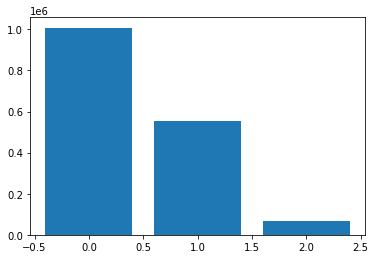

In [29]:
bmi_ref = valid_df.loc[:,["체중(5Kg단위)", "신장(5Cm단위)"]]
bmi_df = (bmi_ref["체중(5Kg단위)"] / ((bmi_ref["신장(5Cm단위)"]/100)**2))
bmi_df = round(bmi_df)

copy_df_bmi = valid_df.copy()
copy_df_bmi.insert(get_col_num(copy_df_bmi), 'BMI', bmi_df)

bmi_list = [24.9, 29.9, 34.9]

plot_list = []
print("정보획득량: ", getRangeIG(copy_df_bmi, "BMI", bmi_list))
print(plot_list)
plt.bar(range(len(np.array(plot_list))), np.array(plot_list))
plt.show()



In [16]:
copy_df_waist = valid_df.copy()
copy_df_waist.dropna(subset=["허리둘레"], inplace=True)
copy_df_waist = copy_df_waist.loc[copy_df_waist["허리둘레"] >= 35]
copy_df_waist = copy_df_waist.loc[copy_df_waist["허리둘레"] <= 111.76]

waist_list = [66.04, 71.12, 78.74, 83.82, 104.14, 106.68, 111.76]

print("정보획득량: ", getRangeIG(copy_df_waist, "허리둘레", waist_list))




H(허리둘레):  0.3623876276400057
정보획득량:  0.018175843898836974


In [ ]:
man_df = valid_df.loc[valid_df["성별코드"] == 1].copy()
woman_df = valid_df.loc[valid_df["성별코드"] == 2].copy()

man_df.dropna(subset=["감마지티피"], inplace=True)
woman_df.dropna(subset=["감마지티피"], inplace=True)

man_range= [10, 63, 99, 199, 599, 1000]
woman_range = [7, 35, 99, 199, 599, 1000]

print(getRangeIG(man_df, "감마지티피", man_range))
print(getRangeIG(woman_df, "감마지티피", woman_range))


In [ ]:
# valid_df["성별코드"].unique()
# valid_df["연령대코드(5세단위)"].unique()
# valid_df["신장(5Cm단위)"].unique()
# valid_df["체중(5Kg단위)"].unique()

# valid_df.dropna(subset=["허리둘레"], inplace=True)
# valid_df = valid_df.loc[valid_df["허리둘레"] >= 35]
# valid_df = valid_df.loc[valid_df["허리둘레"] <= 111.76]
# valid_df["허리둘레"].unique()